# Generating an Optimal Employee Work Schedule Using Integer Linear Programming

Description at http://blogs.mathworks.com/loren/2016/01/06/generating-an-optimal-employee-work-schedule-using-integer-linear-programming/

See also http://yetanothermathprogrammingconsultant.blogspot.se/2017/01/employee-scheduling-i-matlab-vs-gams.html

We start by loading the first sheet into the `employees` list.

In [1]:
import openpyxl as px

w = px.load_workbook("scheduling.xlsx", read_only=True)
p = w.get_sheet_by_name(name = "Available")

headers = []
employees = []
for row in p.rows:
    if len(headers) == 0:
        for k in row:
            headers.append(k.value)
    else:
        employee = {}
        for k in range(len(headers)):
            employee[headers[k]] = row[k].value
        employees.append(employee)
        
print(employees[0]["EmployeeName"])

SMITH


Then, we load the second sheet into `requirements` and plot what it looks like.

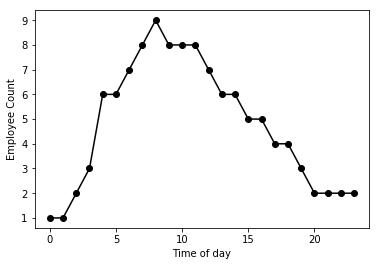

In [2]:
p = w.get_sheet_by_name(name = "Required")
requirements = []
for row in p.rows:
    if 'Requirement' in row[0].value:
        for k in range(24):
            requirements.append(int(row[k + 1].value))
            
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(requirements, "ko-")
plt.xlabel("Time of day")
plt.ylabel("Employee Count");

Create a `can_work` matrix specifying whether an employee can work a specific hour.

In [3]:
can_work = np.zeros((len(employees), 2 * 24))

for e in range(len(employees)):
    avail = employees[e]["Availability"]
    if len(avail) > 0:
        for r in avail.split(","):
            start, end = r.split("-")
            for h in range(int(start), int(end)):
                can_work[e, h] = 1
    else:
        for h in range(24):
            can_work[e][h] = 1
    
    # Duplicate for wrap-around.
    can_work[e][24:] = can_work[e][:24]

from minimum.linear.jupyter import display_2d
display_2d(can_work[:, :24], row_name_function=lambda e: employees[e]["EmployeeName"])

Now, create the IP and generate all possible shifts. Every shift gets a boolean variable.

In [4]:
from minimum.linear.ip import IP
from minimum.linear.sum import Sum
ip = IP()

num_shifts = 0
for e in range(len(employees)):
    max_hours = int(employees[e]["MaxHours"])
    min_hours = int(employees[e]["MinHours"])
    employees[e]["Shifts"] = []
    shift_for_employee = Sum(0)
    
    for h in range(24):
        for duration in range(min_hours, max_hours + 1):
            if np.all(can_work[e, h: h+duration] == 1):
                shift = {}
                shift["Hours"] = list(range(h, h + duration))
                x = ip.add_boolean()
                shift["Variable"] = x
                shift_for_employee += x
                shift["Cost"] = duration * int(employees[e]["HourlyWage"])
                
                employees[e]["Shifts"].append(shift)
                num_shifts += 1
                
    ip.add_constraint(shift_for_employee == 1)
      
print(num_shifts, "shifts added.")

1295 shifts added.


Make sure all requirements are fulfilled.

In [5]:
working_in_hour = []
for h in range(24):
    working_in_hour.append(Sum(0))

for e in range(len(employees)):
    c = 0
    for shift in employees[e]["Shifts"]:
        x = shift["Variable"]
        for h in shift["Hours"]:
            working_in_hour[h % 24] += x

for h in range(24):
    ip.add_constraint(working_in_hour[h] >= requirements[h])

The objective function is the sum of all wages.

In [6]:
for e in range(len(employees)):
    for shift in employees[e]["Shifts"]:
        x = shift["Variable"]
        ip.add_objective(shift["Cost"] * x)

Solve the integer program.

In [7]:
from minimum.linear.solver import Solver

solver = Solver()
solutions = solver.solutions(ip)
assert solutions.get()

In [8]:
working = np.zeros((len(employees), 24))
cost = 0
working_in_hour = []
for h in range(24):
    working_in_hour.append(0)

for e in range(len(employees)):
    for shift in employees[e]["Shifts"]:
        x = shift["Variable"]
        if x.value() > 0.5:
            cost += shift["Cost"]
            for h in shift["Hours"]:
                working[e, h % 24] = 1
                working_in_hour[h % 24] += 1
                
print("Cost is", cost)
display_2d(working, row_name_function=lambda e: employees[e]["EmployeeName"])

Cost is 4670


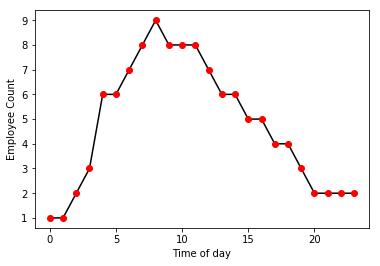

In [9]:
plt.plot(requirements, "k.-")
plt.plot(working_in_hour, "ro")
plt.hold(True)
plt.xlabel("Time of day")
plt.ylabel("Employee Count");